In [46]:
# smarts tutorial
# https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
# 
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
import pandas as pd

def function_label(asmiles):
    function_list = """
[CX3](=O)[OX1H0-,OX2H1] acid
[CX3H1$(C~[#6])](=O) aldehyde
[NX3$(N~[#6])!$(N~[O,S])!$(N=,#[A,a])] anime
[CX4!$(C(=[O]))][OX2H1] alcohol
[c;r][F] ArF
"""
    fg_list = [x.strip() for x in function_list.split('\n')]
    fg_dict = {i.split(" ")[0]:i.split(" ")[1] for i in fg_list if i}
    # print(asmiles)
    amol = Chem.MolFromSmiles(asmiles)
    # print(amol)
    label_list = []

    for asmarts,alabel in fg_dict.items():
        if amol.HasSubstructMatch(Chem.MolFromSmarts(asmarts)):
            label_list.append(alabel)
    final_label = ";".join(label_list)
    return final_label 


def label_ringsystem(asmiles):
    ring_related_atom = """
spiro_atom [X4;R2;r3,r4,r5,r6]@[*;R1;r3,r4,r5,r6]
fused_atom [*;R2][*;R2]
isolation *!@*
"""
    ring_list = [x.strip() for x in ring_related_atom.split('\n')]
    ring_dict = {i.split(" ")[0]:i.split(" ")[1] for i in ring_list if i}

    label_list = []
    amol = Chem.MolFromSmiles(asmiles)

    spiro_atom = Chem.MolFromSmarts(ring_dict["spiro_atom"])
    if len(amol.GetSubstructMatches(spiro_atom)) == 4:
        label_list.append("spiro")

    fused_atom = Chem.MolFromSmarts(ring_dict["fused_atom"])
    if amol.HasSubstructMatch(fused_atom):
        label_list.append("fused")

    isolation = Chem.MolFromSmarts(ring_dict["isolation"])
    if not amol.HasSubstructMatch(isolation):
        label_list.append("isolation")
    final_label = ";".join(label_list)
    return final_label

In [40]:
chembl_data = pd.read_csv("chembl_drug.csv",sep=";")
chembl_data.dropna(subset=["Smiles"],inplace=True)
chembl_data["reactive_label"] = chembl_data["Smiles"].apply(lambda x:function_label(x))
chembl_data["ring_label"] = chembl_data["Smiles"].apply(lambda x:label_ringsystem(x))

[21:08:50] WARNING: not removing hydrogen atom without neighbors
[21:08:50] WARNING: not removing hydrogen atom without neighbors
[21:08:50] WARNING: not removing hydrogen atom without neighbors
[21:08:51] WARNING: not removing hydrogen atom without neighbors
[21:08:51] WARNING: not removing hydrogen atom without neighbors
[21:08:51] WARNING: not removing hydrogen atom without neighbors
[21:08:51] WARNING: not removing hydrogen atom without neighbors
[21:08:55] WARNING: not removing hydrogen atom without neighbors
[21:08:55] WARNING: not removing hydrogen atom without neighbors
[21:08:55] WARNING: not removing hydrogen atom without neighbors
[21:08:56] WARNING: not removing hydrogen atom without neighbors
[21:08:56] WARNING: not removing hydrogen atom without neighbors
[21:08:56] WARNING: not removing hydrogen atom without neighbors
[21:08:56] WARNING: not removing hydrogen atom without neighbors


,Smiles,reactive_label,ring_label,ROMol
0,CC(C)C(C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1)c1ccc(C...,,,
1,CCOC(=O)NC(=S)Nc1ccccc1NC(=S)NC(=O)OCC,anime,,
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3C=...,alcohol,spiro;fused,
3,CSCCC(O)C(=O)O,acid;alcohol,,
4,CCc1ncnc2cc(OC)c(OC)cc12,,fused,
5,CC(C)c1[nH]c2ccccc2c1C(=O)c1cccnc1,,fused,
6,CCN(CC)C(=O)CSc1ccc(Cl)nn1,anime,,
7,CNC(C)C(=O)c1ccc(OC)cc1,anime,,
8,NC(Cc1ccc(Cl)cc1)C(=O)O,acid;anime,,
9,CC(C)COC(=O)OCN1C(=O)CN(CCN2CC(=O)N(COC(=O)OCC...,anime,,

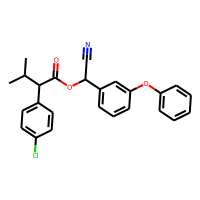
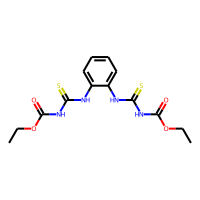
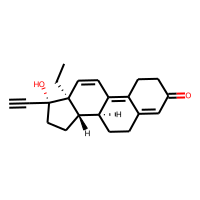
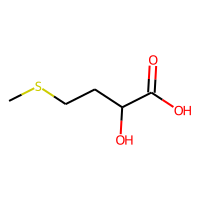
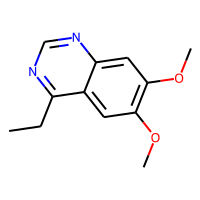
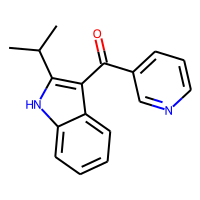
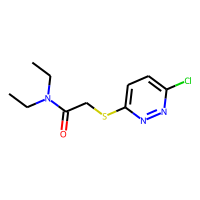
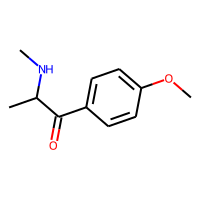
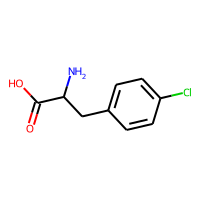
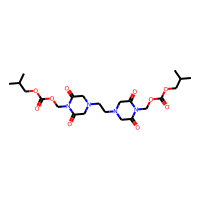

In [47]:

temp_list = chembl_data.head(10)[["Smiles","reactive_label","ring_label"]]
PandasTools.AddMoleculeColumnToFrame(temp_list,smilesCol="Smiles")
temp_list

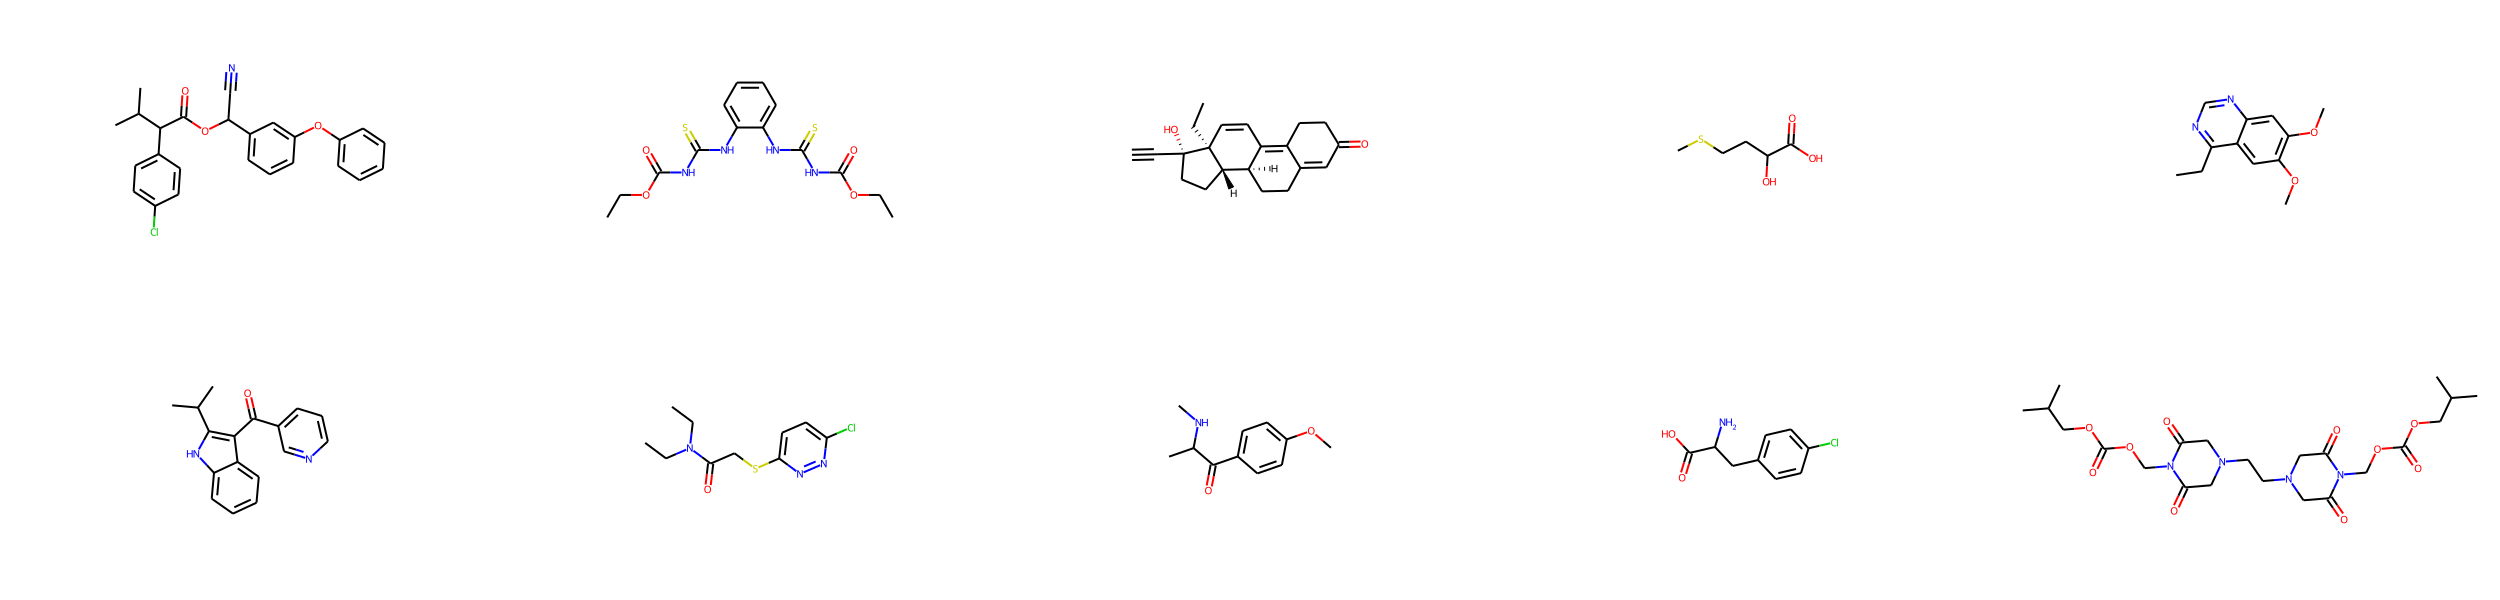

In [72]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

Draw.MolsToGridImage(temp_list["ROMol"],molsPerRow=5,subImgSize=(500,300),useSVG=False)

### highligtAtom

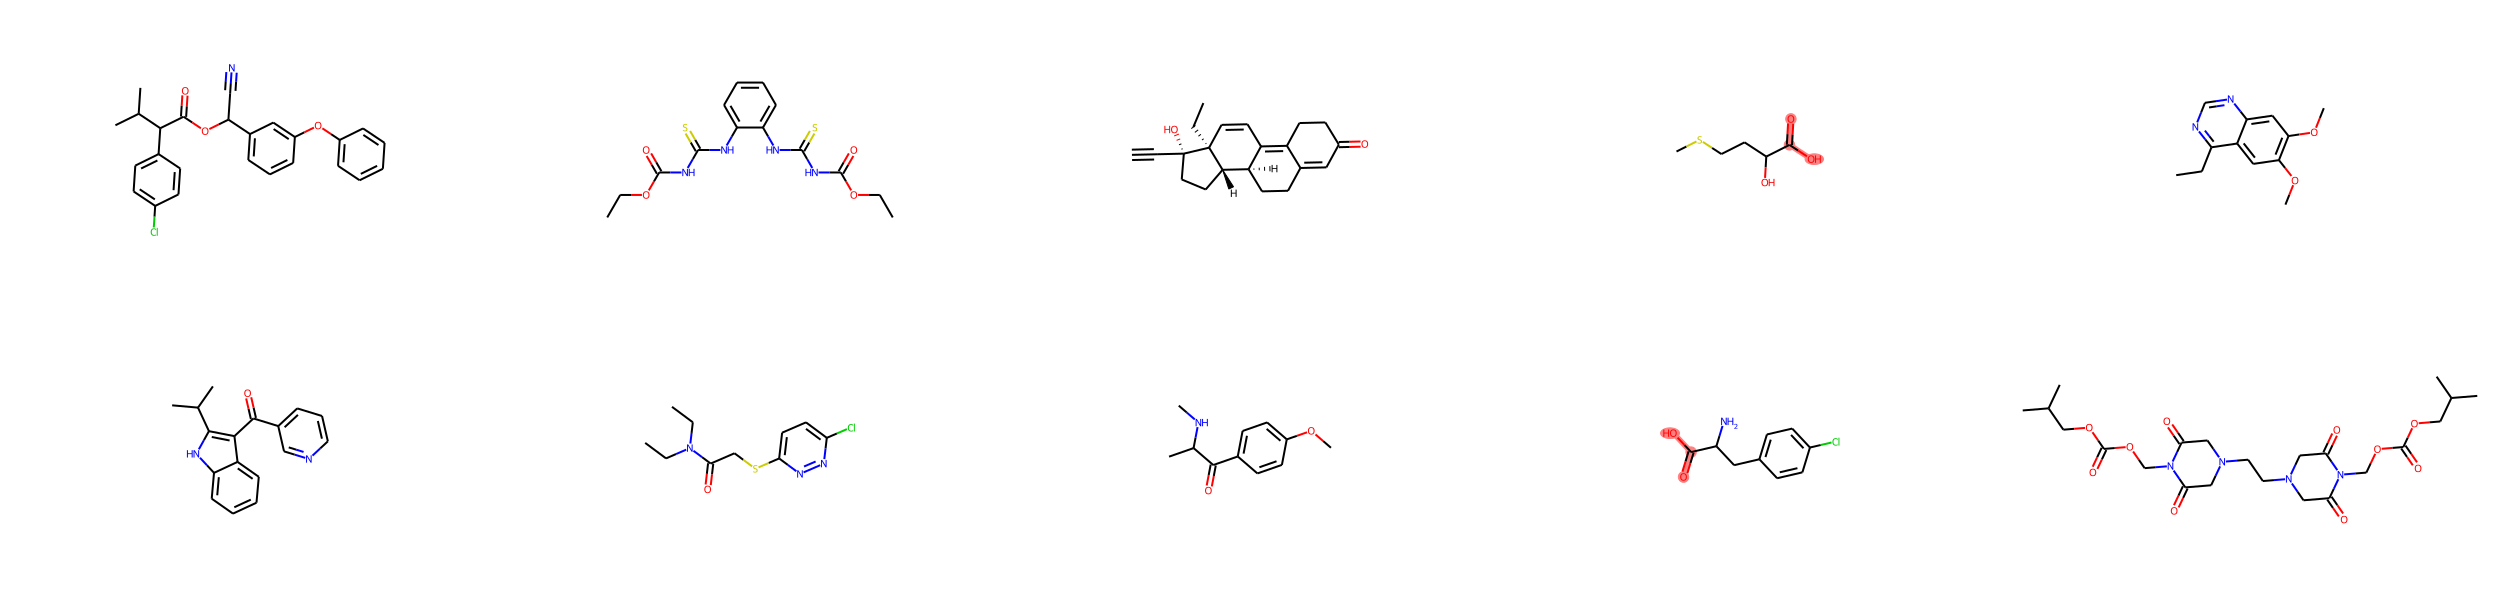

In [52]:
highlight_list = [mol.GetSubstructMatch(Chem.MolFromSmarts("[CX3](=O)[OX1H0-,OX2H1]")) for mol in temp_list.ROMol]
Draw.MolsToGridImage(temp_list["ROMol"],molsPerRow=5,subImgSize=(500,300),
                     highlightAtomLists=highlight_list,useSVG=False)

## mol recap


# recap
<!-- https://blog.csdn.net/Yinger_2000/article/details/110207378 -->
Recap可以模仿实验室中的正向合成过程来进行逆向操作，对分子进行一系列的转换与分解，最终得到一组合理的分子片段。Recap可以对拆解过程进行追踪，并形成类似树的数据结构。原始分子记为根节点（root），被拆解的分子记为父节点（parent），拆解得到的分子记为子节点(children)，某节点下的所有分支节点为子孙节点(all children)，某节点上的所有父节点为祖先节点（ultimate parents），无法继续拆解分子记为叶子节点(leaves)。

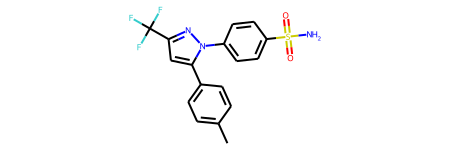

In [57]:
from rdkit.Chem import Recap
import pubchempy as pcp

test_mol = pcp.get_compounds('celecoxib', 'name')
celecoxib = test_mol[0]
smiles = celecoxib.canonical_smiles
celecoxib = Chem.MolFromSmiles(smiles)
celecoxib

In [58]:
decomp = Chem.Recap.RecapDecompose(celecoxib)
decomp

In [59]:
# get recap tree
def get_leaves(recap_decomp,n=1):
    for child in recap_decomp.children.values():
        print('\t'*n+child.smiles)
        if child.children:
            get_leaves(child,n=n+1)

def get_recap_tree(mol):
    recap = Chem.Recap.RecapDecompose(mol)
    print(Chem.MolToSmiles(mol))
    get_leaves(recap)

get_recap_tree(celecoxib)

Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1
	*c1ccc(S(N)(=O)=O)cc1
	*n1nc(C(F)(F)F)cc1-c1ccc(C)cc1
		*c1ccc(C)cc1
		*c1cc(C(F)(F)F)nn1*
	*c1ccc(C)cc1
	*c1cc(C(F)(F)F)nn1-c1ccc(S(N)(=O)=O)cc1
		*c1cc(C(F)(F)F)nn1*
		*c1ccc(S(N)(=O)=O)cc1


In [69]:
# 叶子节点函数：GetLeaves()
# 子孙节点函数：GetAllChildren()
# 祖先节点函数，返回列表：getUltimateParents()
decomp.GetLeaves().keys()

dict_keys(['*c1ccc(S(N)(=O)=O)cc1', '*c1ccc(C)cc1', '*c1cc(C(F)(F)F)nn1*'])

In [70]:
decomp.GetAllChildren().keys()

dict_keys(['*c1ccc(S(N)(=O)=O)cc1', '*n1nc(C(F)(F)F)cc1-c1ccc(C)cc1', '*c1ccc(C)cc1', '*c1cc(C(F)(F)F)nn1*', '*c1cc(C(F)(F)F)nn1-c1ccc(S(N)(=O)=O)cc1'])

## mol BRICS
Rdkit中还有一种BRICS算法，同样可以用于拆解分子。
与recap不同，该算法是根据键是否能够合成来进行拆解。
该方法返回一个经过去重的列表，在原子上的序号对应一种特定的反应类型。

In [71]:
from rdkit.Chem import BRICS

frag_list = BRICS.BRICSDecompose(celecoxib)
frag_list

{'[16*]c1ccc(C)cc1',
 '[16*]c1ccc(S(N)(=O)=O)cc1',
 '[8*]C(F)(F)F',
 '[9*]n1nc([14*])cc1[14*]'}

## BRICSBuild
BRICS模块除了支持拆解分子，也可以对一组片段进行合成：BRICS.BRICSBuild()
返回一个生成器，可以通过next()来获取元素
生成的分子也是未经过核对的，可以对分子重新计算一下隐式化合价、环相关等属性，并做更新：UpdatePropertyCache()

In [73]:
allfrags = set()
for amol in temp_list.ROMol:
    pieces = BRICS.BRICSDecompose(amol)
    allfrags.update(pieces)
print(len(allfrags))

32


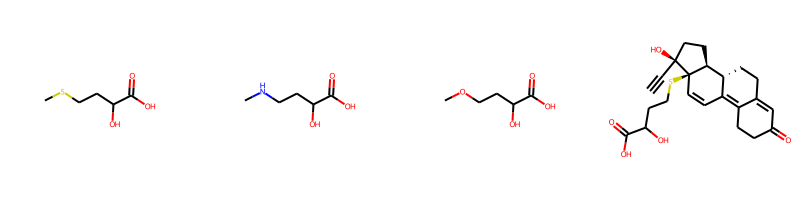

In [74]:
fragms = [Chem.MolFromSmiles(x) for x in sorted(allfrags)]
ms = BRICS.BRICSBuild(fragms)
prods = [next(ms) for x in range(4)]
[prod.UpdatePropertyCache(strict=False) for prod in prods]
Chem.Draw.MolsToGridImage(prods, molsPerRow=4, subImgSize=(200, 200))